In [1]:
# This cell should be exactly the same between all models

import pickle as pk

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from common import *
from util import *

# Load everything
scaled_data = {}
with np.load(PREPROCESSED_DATASET_FILEPATH) as npz_loader:
    for key in npz_loader:
        scaled_data[key] = npz_loader[key]
scaler = pk.load(open(PREPROCESSING_SCALER_FILEPATH, "rb"))

# Input and output dims
input_shape = tuple(list(scaled_data['x_train'].shape)[1:])
output_shape = tuple(list(scaled_data['y_train'].shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

In [2]:
output_shape

(12, 207, 2)

In [3]:
print("tensorflow: {}".format(tf.__version__))
print("numpy: {}".format(np.__version__))

tensorflow: 2.8.0
numpy: 1.21.5


In [4]:
# CONSTANTS:
MODEL_NAME = "SimpleGCN"

In [5]:
sensor_locations_df = pd.read_csv(SENSOR_LOCATIONS_FILE,index_col=0)
sensor_distances_df = pd.read_csv('/Users/varunursekar/Projects/advDeepLearning/final_project/DCRNN-master/data/sensor_graph/distances_la_2012.csv')
# sensor_locations_df = pd.read_csv(SENSOR_LOCATIONS_FILE,names=['sensor_id','latitude','longitude'])
# sensor_distances_df = pd.read_csv('/Users/varunursekar/Projects/advDeepLearning/final_project/DCRNN-master/data/sensor_graph/distances_bay_2017.csv',
#                                   names=['from','to','cost'])


sensor_to_id = dict(zip(sensor_locations_df['sensor_id'].values,np.arange(len(sensor_locations_df))))
distances = np.inf*np.ones((len(sensor_locations_df),len(sensor_locations_df)))


for index, row in sensor_distances_df.iterrows():
    
    if row['from'] in sensor_to_id and row['to'] in sensor_to_id:
        distances[sensor_to_id[row['from']],sensor_to_id[row['to']]] = row['cost']    

In [8]:
def adjacency_from_distances(distances,kappa=0.5,normalize=False,symmetrize=False):
    
    finite_distances = distances[np.isfinite(distances)].flatten()    
    var = np.var(finite_distances)    
    adj = np.exp(-distances**2/var)
    
    adj[adj<kappa] = 0
    
    if symmetrize:
        adj = 0.5*(adj + adj.T)
    
    if normalize:
        adj = adj/np.sum(adj,axis=1)[:,np.newaxis]
    
    return adj

Number of edges =  572
Min number of neighbours= 1
Max number of neighbours= 7
Metal device set to: Apple M1 Max


2022-04-21 12:12:59.102112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-21 12:12:59.102278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


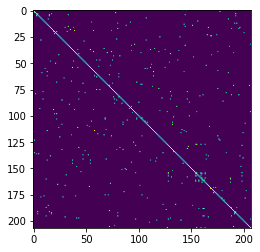

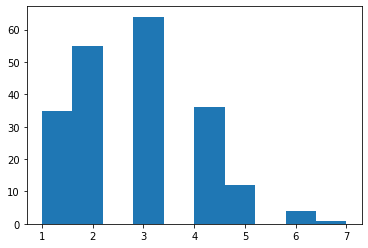

In [9]:
class SimpleGC(tf.keras.layers.Layer):
    
    def __init__(self,per_node_in_feats,per_node_out_feats,A):
        super().__init__()
        
        self.per_node_in_feats = per_node_in_feats
        self.per_node_out_feats = per_node_out_feats
        
        self.A = tf.Variable(A,trainable=False, dtype="float32")
        self.W = tf.Variable(initial_value=tf.keras.initializers.glorot_uniform()(
                                           shape=(per_node_in_feats, per_node_out_feats), dtype="float32"),
                             trainable=True)
        self.activation = tf.keras.layers.ReLU()
    
    def call(self,x):
        
        """
        x : (nodes,batch,time,per_node_in_dims)
        output: (nodes,batch,time,per_node_out_dims)
        """
        
        out = tf.matmul(x,self.W)
        out = tf.matmul(self.A,out)
        out = self.activation(out)
        
        return out
        
    
class LSTMGNN(tf.keras.Model):
    
    def __init__(self,per_node_in_feats,per_node_out_feats,A,output_shape):
        super().__init__()
        
        self.gc1 = SimpleGC(per_node_in_feats,per_node_out_feats,A)
        self.reshape1 = tf.keras.layers.Reshape((output_shape[0],-1))
        self.lstm = tf.keras.layers.LSTM(256, activation="tanh",
                                         return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(256, activation="tanh",
                                         return_sequences=False)
        self.final_dims = output_shape[-1]*output_shape[-2]*output_shape[-3]
        self.final = tf.keras.layers.Dense(self.final_dims,activation='linear')
        self.reshape2 = tf.keras.layers.Reshape(output_shape)
        
    def call(self,x):
        
        out = self.gc1(x)
        out = self.reshape1(out)
        out = self.lstm(out)
        out = self.lstm2(out)
        out = self.final(out)
        out = self.reshape2(out)
        
        return out
        
adj = adjacency_from_distances(distances,kappa=0.6,normalize=False)

plt.figure()
plt.imshow(adj)

print("Number of edges = ",np.sum(adj>0))
plt.figure()
plt.hist(np.sum(adj>0,axis=1))
print("Min number of neighbours=",np.min(np.sum(adj>0,axis=1)))
print("Max number of neighbours=",np.max(np.sum(adj>0,axis=1)))


model = LSTMGNN(2,16,adj,output_shape)

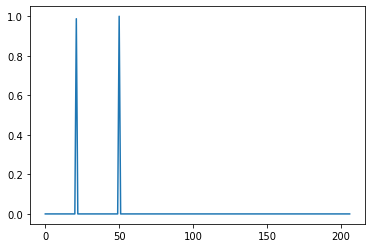

In [10]:
plt.plot(adj[50])

In [11]:
# hyperparameters and callbacks

BATCH_SIZE = 64
MAX_EPOCHS = 100

def scheduler(epoch, lr):
    if epoch<50:
        return lr
    elif epoch%20==0:
        return lr/10
    else:
        return lr
    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(1e-3))
model(scaled_data['x_train'][:5])
model.summary()

Model: "lstmgnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_gc (SimpleGC)        multiple                  42881     
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 lstm (LSTM)                 multiple                  3654656   
                                                                 
 lstm_1 (LSTM)               multiple                  525312    
                                                                 
 dense (Dense)               multiple                  1276776   
                                                                 
 reshape_1 (Reshape)         multiple                  0         
                                                                 
Total params: 5,499,625
Trainable params: 5,456,776
Non-tra

In [13]:
# Compile and fit model here
history = model.fit(
    x=scaled_data['x_train'],
    y=scaled_data['y_train'],
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=(scaled_data['x_val'],
    scaled_data['y_val']),
    callbacks=[callback_lr,callback_es]
)

Epoch 1/100
375/375 [==============================] - 10s 28ms/step - loss: 0.1903 - val_loss: 0.1984 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - 10s 28ms/step - loss: 0.1868 - val_loss: 0.1947 - lr: 0.0010
Epoch 3/100
375/375 [==============================] - 11s 28ms/step - loss: 0.1840 - val_loss: 0.2009 - lr: 0.0010
Epoch 4/100
375/375 [==============================] - 11s 28ms/step - loss: 0.1816 - val_loss: 0.1834 - lr: 0.0010
Epoch 5/100
375/375 [==============================] - 10s 28ms/step - loss: 0.1803 - val_loss: 0.1920 - lr: 0.0010
Epoch 6/100
375/375 [==============================] - 10s 28ms/step - loss: 0.1798 - val_loss: 0.1925 - lr: 0.0010
Epoch 7/100
375/375 [==============================] - 10s 28ms/step - loss: 0.1782 - val_loss: 0.1915 - lr: 0.0010
Epoch 8/100
375/375 [==============================] - 11s 28ms/step - loss: 0.1747 - val_loss: 0.1913 - lr: 0.0010
Epoch 9/100
375/375 [==============================] - 10s 28ms/step - l

In [14]:
# Compute unnormalized prediction loss

preds = {}

for split in ['test','val']:
    preds[split] = model.predict(scaled_data['x_'+split])
    preds[split] = scaler.inverse_transform(preds[split])

2022-04-21 12:23:36.768985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-21 12:23:36.836913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-21 12:23:36.958008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [15]:
# Save model
# model.save(model_name_to_model_filepath(MODEL_NAME))

# Save run info
run_info = {}
run_info["history"] = history.history
run_info["predictions"] = preds # idk whether this part makes sense for RNNs or not
pk.dump(run_info, open(model_name_to_run_info_filepath(MODEL_NAME), "wb"))